# Introduction to Generative Modelling

In generative modelling, we assume some data is drawn from an underlying probability distribution. If we can learn this underlying distribution, we can then use it to generate realistic samples.

In [1]:
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

np.random.seed(0)


For example, if we plot the height, $X \in \mathbb{R}$, of a real-world sample of 25,000 18-year-olds drawn from a population, we can visualise an empirical approximation of the probability density function, $p_X(x)$ that describes the true underlying generating distribution

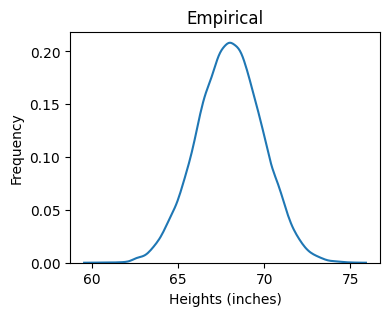

In [2]:
data = pd.read_csv("./datasets/SOCR-HeightWeight.csv")

empirical_heights = data["Height(Inches)"]

plt.figure(figsize=(4,3))
sns.kdeplot(empirical_heights)
plt.xlabel("Heights (inches)")
plt.ylabel("Frequency")
plt.title("Empirical")
plt.show()

We can see that the height of 18-year-olds, $X$, appears to be normally distributed. The simplest way to model this distribution would then be to assume that $X$ is drawn from a Gaussian (normal) distribution parameterised by the mean, $\mu_\text{height}$, and standard deviation, $\sigma_\text{height}$ of our sample:

$$X\sim\mathcal{N}(\mu_\text{height}, \sigma_\text{height})$$

Equivalently, the above function is mathematically described by:
$$p_X(x)=\frac{1}{\sigma_\text{height}\sqrt{2\pi}}\exp\left(-\frac{(x-\mu_\text{height})^2}{2\sigma^2_\text{height}}\right)$$

This defines our first generative model!

We can now draw samples of $X$ from this distribution, $\mathcal{N}(\mu_\text{height}, \sigma_\text{height})$, and plot them in the same manner we did earlier.

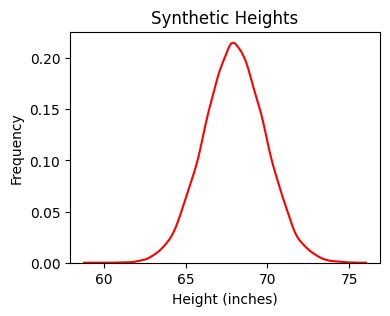

In [3]:
mean = np.mean(empirical_heights)
stdev = np.std(empirical_heights)

synthetic_heights = norm.rvs(mean, stdev, size=25000)

plt.figure(figsize=(4,3))
sns.kdeplot(synthetic_heights, color="red")
plt.xlabel("Height (inches)")
plt.ylabel("Frequency")
plt.title("Synthetic Heights")
plt.show()

Overlaying our synthetic data with our empirical data demonstrates that we have obtained a very good model of the true generating distribution.

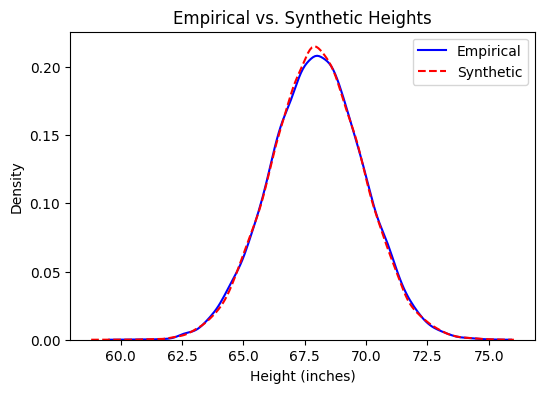

In [4]:
plt.figure(figsize=(6,4))
sns.kdeplot(empirical_heights, label="Empirical", color="blue")
sns.kdeplot(synthetic_heights, label="Synthetic", color="red", linestyle="--")

plt.xlabel("Height (inches)")
plt.ylabel("Density")
plt.title("Empirical vs. Synthetic Heights")
plt.legend()

Let's introduce some complexity into the mix. We'll now consider a different dataset, which includes height, weight, and gender.

In [5]:
data = pd.read_csv("./datasets/weight-height.csv")

data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Let's plot the distribution of weights and take a look.

<Axes: xlabel='Weight', ylabel='Density'>

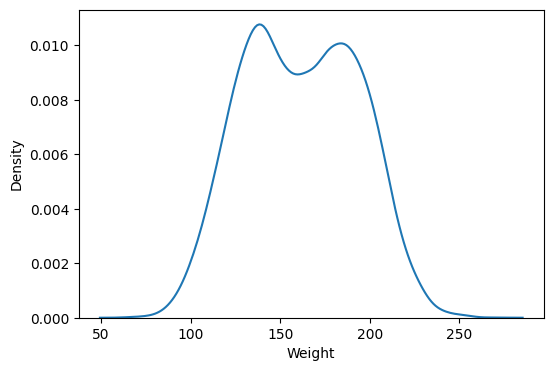

In [6]:
plt.figure(figsize=(6,4))
sns.kdeplot(data["Weight"])


We could try the same as before, and use a Gaussian distribution as a basis for a generative model, where:
$$X\sim\mathcal{N}(\mu_\text{weight}, \sigma_\text{weight})$$

Mathematically described by:
$$p_X(x)=\frac{1}{\sigma_\text{weight}\sqrt{2\pi}}\exp\left(-\frac{(x-\mu_\text{weight})^2}{2\sigma^2_\text{weight}}\right)$$

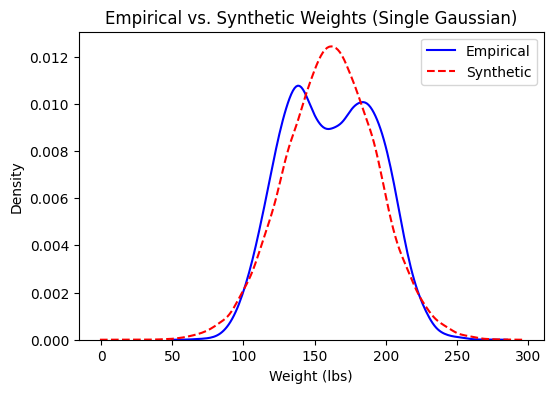

In [7]:
mean = np.mean(data["Weight"])
stdev = np.std(data["Weight"])

synthetic_weights = norm.rvs(mean, stdev, size=25000)

plt.figure(figsize=(6,4))
sns.kdeplot(data["Weight"], label="Empirical", color="blue")
sns.kdeplot(synthetic_weights, label="Synthetic", color="red", linestyle="--")
plt.xlabel("Weight (lbs)")
plt.ylabel("Density")
plt.title("Empirical vs. Synthetic Weights (Single Gaussian)")
plt.legend()

It's close, but we can do better. Because we know something about the data, we know that there exists some latent (unobserved) variable, $z$ - representing gender - that plays an important role in defining our distribution. The data, as plotted above, is the **marginal distribution** - i.e., the distribution *irrespective of $z$*. 

Formally, this marginal distribution arises from averaging over the latent variable:
$$p(x)=\sum_z p(x|z)\cdot p(z),\quad z\in\set{\text{Male}, \text{Female}}$$
Think of it like this: the probability (density) of any datapoint is equal to the conditional probability (i.e., 'What is the probability of seeing this data ($x$) if the subject were \{male/female\} ($z$)?') multiplied by the probability of the latent variable $z$, summed over all possible values of $z$. 

If that feels like a lot - all we're saying is that the **marginal distribution is the distribution of weights ($x$) irrespective of gender ($z$)**.

Now, let's see what happens if we condition on $z$ (i.e., incorporate the latent variable - gender - into the distribution).

<Axes: xlabel='Weight', ylabel='Density'>

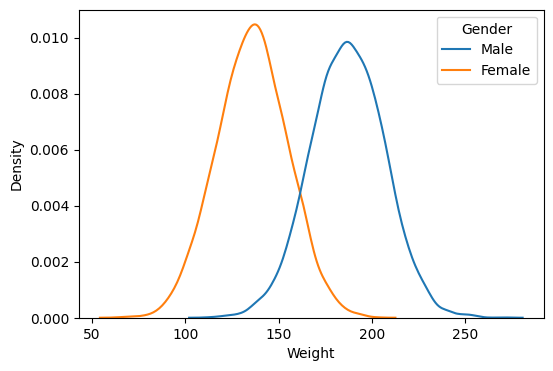

In [8]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=data, x="Weight", hue="Gender")

We see that the data separates cleanly into two distinct Gaussian-like distributions - one for males, one for females. The **overall** (marginal) distribution (the one we saw above) can then be described as a **mixture of Gaussians**, where each component (each Gaussian) corresponds to a different value of the latent variable (one Gaussian for male, one for female). 

We know, then, that the marginal distribution can be described by some combination of these two Gaussians. Let's formalise that:
$$p(x)=\sum_{k=1}^K \pi_k \cdot \mathcal{N}(x|\mu_k, \sigma^2_k)$$
where each $k$ corresponds to one of the Gaussian components and $\pi_k$ is a mixing weight ($\sum_k \pi_k =1$) that describes how much each component contributes to the marginal distribution. If we had a dataset of 70\% males and 30\% females, then $\pi_\text{Male}=0.7$ and $\pi_\text{Female}=0.3$ - the Gaussian representing the latent group 'Male' would have a higher contribution to the marginal distribution.

This formula describes a **Gaussian Mixture Model (GMM)**. It can be used as a generative model (among other uses) for more complex distributions. Because our dataset is neatly divided by our latent variable, we can very easily parameterise our GMM by calculating the weighting of each gender alongside their respective means and variances.

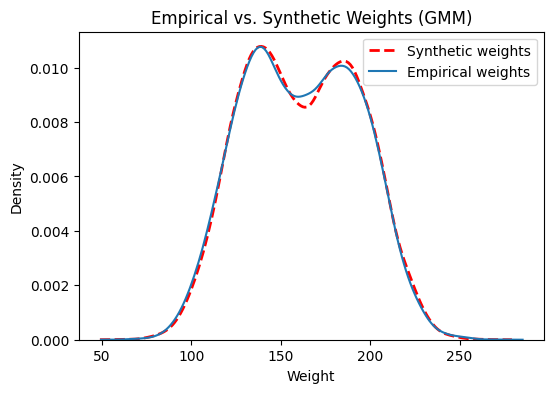

In [9]:
# Separate weights by gender
male_weights = data.loc[data["Gender"] == "Male", "Weight"]
female_weights = data.loc[data["Gender"] == "Female", "Weight"]

# Calculate statistics separately for each gender
mean_m, stdev_m = male_weights.mean(), male_weights.std()
mean_f, stdev_f = female_weights.mean(), female_weights.std()

# Calculate the mixing weights, pi_k
pi_m = len(male_weights) / len(data)
pi_f = len(female_weights) / len(data)

# Define number of samples to generate
N = 25000

# Randomly compose an array of 'Male' and 'Female' of size N, selected with probability pi_k
z = np.random.choice(["Male", "Female"], size=N, p=[pi_m, pi_f])

# Generate the weights
synthetic_weights = np.where(
    z == "Male", # If the array entry is Male
    norm.rvs(mean_m, stdev_m, size=N), # Generate from the male Gaussian
    norm.rvs(mean_f, stdev_f, size=N) # Otherwise, generate from the female Gaussian
)

# Plot the results
plt.figure(figsize=(6,4))
sns.kdeplot(synthetic_weights, label="Synthetic weights", color="red", linestyle="--", linewidth=2)
sns.kdeplot(data["Weight"], label="Empirical weights")
plt.title("Empirical vs. Synthetic Weights (GMM)")
plt.legend()



Great! We've built a well-defined generative model for our bi-modal distribution - but that felt a little bit like cheating. In practice, we'll rarely get datasets where the latent variable is neatly labelled. If $z$ (gender, in our case) is truly unobserved, then we no longer know which data point belongs to which Gaussian component. So how do we recover the Gaussian components and their respective mixing weights?

This is where the **Expectation Maximisation (EM)** algorithm comes in. EM provides a way to fit a Gaussian mixture model without ever directly observing the latent variable. It works in a two-step iterative process: 
1. **E-step (Expectation)**: estimate the probability that each datapoint belongs to each Gaussian component.
2. **M-step (Maximise)**: update the parameters (mean, variance, mixture weight) of each component using these probabilities.

The goal of this process is to **maximise the likelihood of the data under our mixture model**. Though under the EM algorithm we do not directly compute or involve the likelihood (the likelihood is maximised as a result of the monotonicity - only increasing - property of the EM algorithm), it is going to crop up a lot in subsequent notebooks, and so it is worth a quick side-bar.

 The likelihood tells us how well a set of model parameters explains the data we've actually observed. Intuitively, it answers the question 'If this model were true, how probable is it that we would have seen this dataset?' - so, for a poor model (for example, our earlier Gaussian on the bi-modal distribution), it would be very improbable that we would see the empirical distribution that we did. For a better model, like our Gaussian mixture model, it is much more probable that we would see our empirical distribution.

We can formalise the likelihood for a set of datapoints $\set{x_i}_{i=1}^N$ as:
$$\mathcal{L}(\theta)=\prod_{i=1}^N\sum_{k=1}^K \pi_k \cdot \mathcal{N}(x_i|\mu_k, \sigma_k^2)$$
where $\mathcal{L}(\theta)$ is the likelihood of the data under a GMM parameterised by $\theta=\set{\pi_k, \mu_k, \sigma^2_k}^K_{k=1}$ - the set of parameters that govern our model (the mixture weights $\pi_k$, the mean $\mu_k$ of component $k$, and the variance $\sigma_k$ of component $k$).

In practice, working with a product of sums can become a bit messy - a large or very small component can quickly cause the likelihood to explode or vanish. Instead, we almost always work with the **log likelihood**, which has the advantage of being much more numerically stable:
$$\log \mathcal{L}(\theta) = \sum_{i=1}^N\log \left(\sum_{k=1}^K\pi_k\cdot\mathcal{N}(x_i|\mu_k, \sigma^2_k)\right)$$

Back to the **Expectation Maximisation (EM)** algorithm.

We won't start completely unhindered. If we encountered this dataset in the wild, we might reasonably surmise that the weights are distributed differently by sex, which suggests that there are probably two underlying components, so we know we want to fit a model with two Gaussians. To start, we'll initialise these components with some parameters. Let's say we'll assign a weight of $0.5$ to each component, i.e., $\pi_\text{Male} = 0.5$, $\pi_\text{Female}=0.5$, and we'll assign random means and variances.

It's worth thinking about the EM algorithm like this (before we delve into the maths): for each datapoint in our dataset, we want to ask 'what is the probability that this point came from each of the Gaussian components as they currently stand?'. This gives each datapoint a pair of 'soft labels' that describe how much it 'belongs' to each component. 

Once we have these soft assignments, we can treat them as weights that tell us how strongly each datapoint contributes to each component. For example, a datapoint that is 80\% likely to be from the male distribution and 20\% from the female distribution contributes 0.8 of its value to the male Gaussian and 0.2 to the female Gaussian. Let's consider a concrete example - a weight of 200lbs is 90\% likely to be drawn from the male component, and 10\% likely to be drawn from the female component. This means that the male Gaussian would receive 180 weight units, and the female would receive 20 units. 

Performed across the whole dataset, we end up with two 'new' datasets - one corresponding to each Gaussian component - that each contain a scaled portion of every single datapoint (in the example we've just looked at, that would mean 'dataset 1' contains $180$ and 'dataset 2' contains $20$ - repeat for every single point). From these 'new' datasets, we can then recalculate the parameters: the new means are the averages of the points, the new variances are the spreads, and the new mixture weights are the average responsibilities each component received.

Let's now formalise that. 

We'll start by initialising our components.


In [ ]:
X = np.array(data["Weight"]) # Shape (N)

# We assume that the marginal distribution is composed of 2 Gaussian components (Male, Female)
K = 2

# Initialise the component weights
pi = np.ones(K) / K # Shape (K,)

# Initialise their means by selecting random datapoints (ensures the means are in-distribution)
Mu = np.random.choice(X, K) # Shape (K,)

# Initialise the variance by taking the variance of the overall dataset (reasonable starting value)
sigma2 = np.full(K, np.var(X)) # Shape (K,)

print("Initial mixture weights: ", pi)
print("Initial means: ", Mu)
print("Initial variances: ", sigma2)

Initial mixture weights:  [0.5 0.5]
Initial means:  [135.01316404 190.32443963]
Initial variances:  [1030.84876025 1030.84876025]


#### **E-step (Expectation)**
For each datapoint $x_i$ and component $k$, calculate the probability that the datapoint $x_i$ belongs to component $k$:
$$\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i|\mu_k, \sigma_k^2)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i|\mu_j, \sigma_j^2)}$$

This is the **responsibility** of each component $k$ for the datapoint $x_i$. 

(recall that $p_X(x)=\frac{1}{\sigma_\text{weight}\sqrt{2\pi}}\exp\left(-\frac{(x-\mu_\text{weight})^2}{2\sigma^2_\text{weight}}\right)$)

In [ ]:
def e_step(X, pi, mu, sigma2):
    # Reshape our data so we can use vector operations
    X = X.reshape(-1, 1) # (N) -> (N, 1)
    mu = mu.reshape(1, -1) # (K,) -> (1, K)
    pi = pi.reshape(1, -1) # (K,) -> (1, K)
    sigma2 = sigma2.reshape(1, -1) # (K,) -> (1, K)
    
    # 1/(sigma * sqrt(2pi))
    normalisation_constant = 1.0 / np.sqrt(2.0 * sigma2 * np.pi)

    # exp(-(X-mu)^2 / 2 * sigma^2)
    exponent_term = np.exp(-(X - mu)**2 / (2 * sigma2))

    # Full pdf matrix where N_ik = N(x_i | mu_k, sigma^2_k)
    pdf = normalisation_constant * exponent_term

    numerators = pi * pdf
    denominators = numerators.sum(axis=1, keepdims=True)

    gamma = numerators / denominators

    return gamma

gamma = e_step(X, pi, Mu, sigma2)


Earlier, we guessed that for $x_i=200\text{lbs}$ we would obtain responsibilities of $\gamma_{i, \text{male}}=0.9$ and $\gamma_{i, \text{female}}=0.1$. 

We can now use this E-step implementation to see what we'd actually get under our initialisations - close!

$\gamma_{i, 1}=0.119$ and $\gamma_{i, 2}=0.881$

In [ ]:
x_200 = np.array([200.0])
e_step(x_200, pi, Mu, sigma2)

array([[0.11888361, 0.88111639]])

We can then define the total responsibility of each component (i.e., across all points, what was the total contribution of each component?):
$$N_k=\sum_{i=1}^N \gamma_{ik}$$

In [13]:
def total_responsibility(gamma):
    return gamma.sum(axis=0)

Nk = total_responsibility(gamma)
Nk

array([5113.23641894, 4886.76358106])

#### **M-step (Maximise)**
Now that we have the responsibility of each component $k$ for each datapoint $x_i$, we can use this information to update our parameters.

We define the new mixing weights, $\pi_k$, as the total responsibility of the component, $N_k$, divided by the total responsibility across all components, $N$:
$$\pi_k=\frac{N_k}{N}$$
This makes sense - if we find that most datapoints are more likely to belong to one component, we would expect that component to have a large effect on the marginal distribution.

In [14]:
def new_pi(gamma, Nk):
    N = Nk.sum()

    pi_k = Nk / N

    return pi_k

pi_k = new_pi(gamma, Nk)
pi_k

array([0.51132364, 0.48867636])

We define the new mean of each component, $\mu_k$, as the mean value of each datapoint $x_i$ multiplied by the responsibility of the component for it, $\gamma_{ik}$:
$$\mu_k=\frac{1}{N_k}\sum_{i=1}^N \gamma_{ik} \cdot x_i$$

In [15]:
def new_mean(X, gamma, Nk):
    X = X.reshape(-1, 1)
    weighted_sum = (gamma * X).sum(axis=0)
    mu_k = weighted_sum / Nk

    return mu_k

mu_k = new_mean(X, gamma, Nk)
mu_k

array([142.4700303 , 181.28984677])

And we define the variance $\sigma^2_k$ as the spread of each datapoint $x_i$ weighed by the responsibility of the component, $\gamma_{ik}$:
$$\sigma^2_k=\frac{1}{N_k}\sum_{i=1}^N \gamma_{ik} \cdot (x_i-\mu_k)^2$$

In [16]:
def new_variance(X, gamma, Nk, mu_k):
    X = X.reshape(-1, 1)
    weighted_spread = (gamma * (X - mu_k)**2).sum(axis=0)
    sigma2_k = weighted_spread / Nk

    return sigma2_k

sigma2_k = new_variance(X, gamma, Nk, mu_k)
sigma2_k

array([648.21470252, 660.66210649])

We can now combine all of these functions and wrap them in a loop so we can rapidly iterate over them. This loop will fit the parameters, $\theta$, of our Gaussian Mixture Model.

In [17]:
def fit_gmm(X, K, max_iters):
    pi = np.ones(K) / K # Assign equal weight to each component
    mu = np.random.choice(X, K, replace=False) # Randomly select datapoints as means for each component
    sigma2 = np.full(K, np.var(X)) 

    for _ in range(max_iters):
        # E step
        gamma = e_step(X, pi, mu, sigma2)

        # M step
        Nk = total_responsibility(gamma) # Calculate the total responsibility
        pi = new_pi(gamma, Nk) # Calculate the new mixture weights
        mu = new_mean(X, gamma, Nk) # Calculate the new means
        sigma2 = new_variance(X, gamma, Nk, mu) # Calculate the new variances

    return pi, mu, sigma2

Then, we'll also need a separate function to sample from our newly parameterised GMM. 

In [18]:
def sample_gmm(pi, mu, sigma2, n_samples):
    K = len(pi)

    # Use our mixture weights to randomly choose a component to sample from
    z = np.random.choice(K, size=n_samples, p=pi)

    # Sample from a Gaussian parameterised by the chosen component
    samples = np.random.normal(loc=mu[z], scale=np.sqrt(sigma2[z]), size=n_samples)
    
    return samples

Let's see what happens when we set $K=2$ and perform 100 iterations of our Expectation Maximisation algorithm. We'll generate 10,000 samples.

In [ ]:
K = 2
n_iterations = 100

pi, Mu, sigma2 = fit_gmm(X, K, 100)

n_samples = 10000
samples = sample_gmm(pi, Mu, sigma2, n_samples)

And then we can plot them against our empirical data. 

We've successfully built a very good generative model without ever directly observing the underlying latent variable!

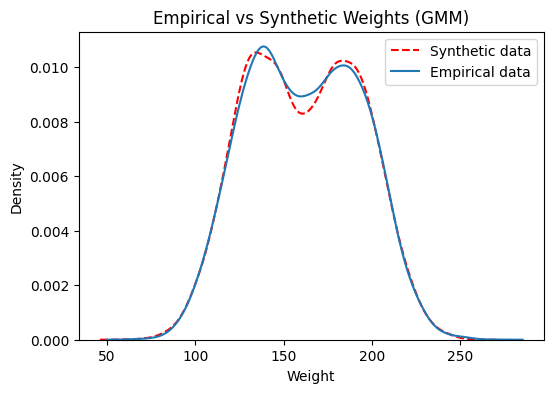

In [20]:
plt.figure(figsize=(6,4))
sns.kdeplot(samples, label="Synthetic data", color="red", linestyle="--")
sns.kdeplot(data["Weight"], label="Empirical data")
plt.title("Empirical vs Synthetic Weights (GMM)")
plt.legend()

## Multivariate Distributions
Great, we've managed to resolve a generative Gaussian Mixture Model for a univariate (one variable - weight) distribution! But what if we have multiple variables (multivariate)? What if, instead of just modelling height, we wanted to model height and weight? What if we wanted to extend into even more dimensions? 

Let's go back to our dataset from earlier.

In [21]:
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


We can visualise the density across two dimensions: weight and height. We can clearly see two yellow blobs where the highest density occurs - these represent our latent variable, gender. 

<Axes: xlabel='Height', ylabel='Weight'>

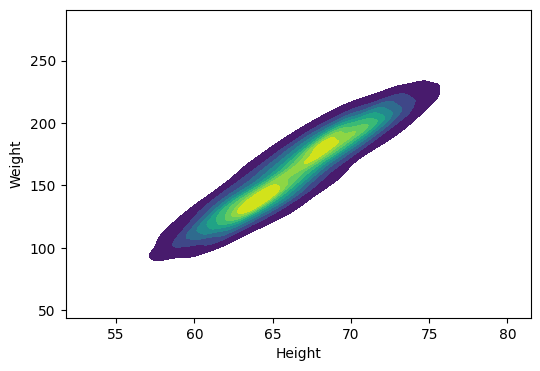

In [22]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=data, x="Height", y="Weight", fill=True, cmap="viridis")

We can make this even clearer when we incorporate gender. Again, these are the two Gaussians we want to fit - except now, instead of fitting univariate Gaussians to height alone, we want to fit multivariate Gaussians to the joint distribution of height and weight.

<Axes: xlabel='Height', ylabel='Weight'>

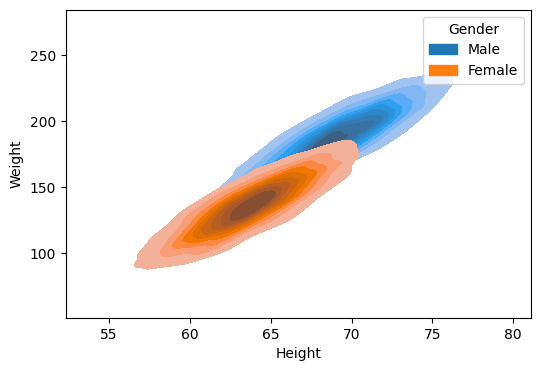

In [29]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=data, x="Height", y="Weight", fill=True, hue="Gender")

This motivates the need for multivariate Gaussian Mixture Models.

Under multivariate Gaussian mixture models with dimensions $d$, each component is defined by:
- A multi-dimensional mean (a vector) that positions the centre of the distribution along each dimension: $$\mu_k \in \mathbb{R}^d$$
- And a **covariance matrix**, which controls the shape of the distribution: $$\Sigma_k\in\mathbb{R}^{d\times d}$$ 

The diagonals of the covariance matrix, $\Sigma_{ii}$ are the variances of each dimension - $\sigma_{i}$ - exactly like in the univariate case. The off-diagonals, $\Sigma_{ij}$ represent the *covariance*, or how two dimensions may vary together:
- If $\Sigma_{ij}>0$, they exhibit positive correlation; 
- if $\Sigma_{ij}<0$, they exhibit negative correlation; 
- and if $\Sigma_{ij}=0$, the two dimensions are uncorrelated (though not necessarily independent).

We can observe special cases of the covariance matrices that can be considered when designing our mixture model:
- **Isotropic covariance**: We assume that variance is the same in all dimensions, i.e., $\Sigma=\sigma^2 I$ (the diagonal is populated by the same value for all dimensions). The Gaussian is then a hypersphere (a sphere in 3D, or a circle in 2D). This is the most restrictive option, allowing components to only differ in mean and size, but not shape, reducing its ability to imitate distributions. The parameter count is equal to the number of components, $k$, as we only have to fit per-dimension mean $\mu_k$ and a single variance parameter $\sigma_k^2$. 
- **Diagonal covariance**: We assume full independence of dimensions, and only encode variances along the diagonal. While simplifying the model (and so perhaps limiting its accuracy), it allows us to fit fewer parameters ($K\times (d + d)$ - each component needs per-dimension means and variances) and so is less computationally expensive.
- **Full covariance**: We include covariances across all dimensions, including the off-diagonals, allowing us to capture correlated features. Allows us to model more complex distributions, but is expensive to estimate as it requires a parameter count of $K\times d \times \frac{(d+1)}{2}$ - each component needs $d$ means and $\frac{d(d+1)}{2}$ covariance parameters.

The probability density function of a multivariate Gaussian distribution is described by:
$$\mathcal{N}(x|\mu_k, \Sigma_k)=\frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2}(x-\mu_k)^\intercal\Sigma_k^{-1}(x-\mu_k)\right)$$

## E-Step
Much the same as before, we first want to calculate the **responsibility** of each component for each datapoint. 

Recall that the responsibility for datapoint $i$ under component $k$ is given by (now accounting for the multivariate case):
$$\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i|\mu_k, \Sigma_k^2)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i|\mu_j, \Sigma_j^2)}$$

where $\mathcal{N}(x|\mu_k, \Sigma_k)=\frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2}(x-\mu_k)^\intercal\Sigma_k^{-1}(x-\mu_k)\right)$.

Note the term $(x-\mu_k)^\intercal\Sigma_k^{-1}(x-\mu_k)$: this refers to the squared **Mahalanobis distance**. It generalises the squared difference term, $\frac{x_i-\mu_k^2}{\sigma^2_k}$, we saw in the univariate case, allowing us to account for correlations between dimensions: even though a point may be closer to the mean in Euclidean terms, when we account for variance, it may represent an edge case, lying in a low-probability region of the distribution. For example, if we consider observing a person who is 200cm tall and 150kg, they are far from the average height or weight - but lie along the main axis of variation (i.e., tall and heavy together); whereas if we consider someone who is 200cm tall and 40kg, the Euclidean distance from the mean may look similar, but this combination falls off-axis (i.e., tall but unusually light; against the expected correlation). Mahalanobis then describes not just how far a point is, but how far given how the variables tend to vary together. This is why, under Mahalanobis distance, distances are shrunk along directions of high variance, and elongated along directions of low variance. 

Let's go over the code.

Our $X$ is a data matrix with shape $(N, d)$.  

The below function will return a matrix of per-datapoint responsibilities, $\Gamma$, with shape $(N, K)$.

In [86]:
def e_step(X, pi, Mu, Sigma2):
    # Number of datapoints N and dimensions per datapoint d
    N, d = X.shape

    # Number of components 
    K = pi.shape[0]

    # Initialise an empty matrix to hold densities per datapoint per component
    pdf = np.zeros((N, K))

    # Sigma2 has shape (K, d, d)
    # Inverse and determinants are only valid for 2-D matrices, so we iterate over each K dimension which has shape (d, d)
    for k in range(K):
        # |Sigma_k|
        cov_determinant = np.linalg.det(Sigma2[k])

        # Sigma^-1
        cov_inverse = np.linalg.inv(Sigma2[k])

        # 1 / (2*pi)**(d/2) * |Sigma_k|**0.5
        normalisation_constant = 1.0 / ((2.0 * np.pi)**(d/2) * np.sqrt(cov_determinant))

        # Calculate x-mu_k
        diff = X - Mu[k] # (N, d)

        # Calculating the Mahalanobis distance per datapoint
        # (x - mu_k).T @ Sigma^-1 @ (x - mu_k) is invalid due to incompatible dimensionality: (d, N) @ (d, d) @ (N, d) -- (d, N) @ (d, d) is invalid
        # We do it per-row instead
        # (x_i - mu_k) @ Sigma^-1: (N, d) @ (d, d) (valid)

        # Apply the inverse of the covariance matrix (Sigma^-1) to each row (datapoint)
        q = diff @ cov_inverse # (N, d) @ (d, d) - > (N, d)

        # Each row of q is (x_i - mu_k) @ Sigma^-1: (N, d)
        # We multiply *element-wise* with (x_i - mu_k) to yield distances per dimension per datapoint: (N, d) * (N, d) -> (N, d)
        # Then we sum across the dimensions (axis=1) to yield a total distance across dimensions in scalar form -> (N, 1)
        mahalanobis_distance = np.sum(q * diff, axis=1)

        # exp(-0.5 * (x-mu_k).T @ Sigma^-1 @ (x-mu_k))
        exponent_term = np.exp(-0.5 * mahalanobis_distance)

        # Populate our pdf matrix for component k 
        pdf[:, k] = normalisation_constant * exponent_term

    numerators = pi * pdf # (N, K)
    denominators = numerators.sum(axis=1, keepdims=True) # (N, 1)

    Gamma = numerators / denominators

    return Gamma
    

Then we can calculate the **total responsibility**, $N_k$, of each component by summing across all datapoints:

$$N_k=\sum_{i=1}^N \gamma_{ik}$$

This remains the same as the univariate case.

The input to the below function is our $\Gamma$ matrix of shape $(N, K)$ and we output shape $(K,)$.

In [87]:
def total_responsibility(Gamma):
    return Gamma.sum(axis=0)

## M-Step
Recall that the M-step involves updating the parameters of the model:
- $\pi$, the mixing weights;
- $\mu$, the means;
- and $\Sigma$, the covariance matrices.

The new mixing weights are defined by: 
$$\pi^{\text{new}}_k=\frac{N_k}{N}$$
where $N$ is the total responsibility across all components.

The code remains the same as the univariate case.

In [88]:
def new_pi(Gamma, Nk):
    N = Nk.sum()

    pi_k = Nk / N

    return pi_k

The new mean of each component is given by:
$$\mu^{\text{new}}_k=\frac{1}{N_k}\sum_{i=1}^N\gamma_{ik}\cdot x_i$$

Parameters:
- $X$: shape $(N, d)$
- $\gamma$: shape $(N, K)$
- $N_k$: shape $(K,)$

The below function does:
$$\frac{\Gamma^\intercal \cdot X}{N_k}$$
Yielding our means matrix, $\Mu$, with shape $(K, N) \cdot (N, d) / (K,) \rightarrow (K, d)$.

In [89]:
def new_mean(X, Gamma, Nk):
    weighted_sum = (Gamma.T @ X)
    Mu = weighted_sum / Nk[:, None]

    return Mu

Finally, we calculate our new covariance, which is given by:

$$\Sigma_k^{\text{new}}=\frac{1}{N_k}\sum_i \gamma_{ik}(x_i-\mu_k)(x_i-\mu_k)^\intercal$$

Recall:
- $N_k$: shape $(K,)$
- $\Gamma$: shape $(N,K)$
- $X$: shape $(N, d)$
- $\Mu$: shape $(K,d)$

And we want to output a covariance matrix per component, i.e., we will yield shape $(K, d, d)$.

In [ ]:
def new_variance(X, Gamma, Nk, Mu):
    N, d = X.shape
    K = Gamma.shape[1]

    Sigma2 = np.zeros((K, d, d))

    for k in range(K):
        # (N, d) - (,d) -> (N,d)
        diff = X - Mu[k]

        # Extract the responsibility of component k, shape (N,1)
        gamma_k = Gamma[:, k][:, None]

        # Weight each difference by the component's responsibility
        W = diff * gamma_k

        # Calculte the average of the weighted deviation's outer products
        # This yields the responsibility-weighted covariance matrix for component k
        Sigma2[k] = W.T @ diff / Nk[k]

    return Sigma2

Finally, we define a loop to fit the parameters of our Gaussian Mixture Model using the above functions.

In [ ]:
def fit_gmm(X, K, max_iters):
    N, d = X.shape
    pi = np.ones(K)

    # Select a random datapoint to be initial mean
    Mu = X[np.random.choice(N, K, replace=False)] 

    # Initialise the covariance matrix
    cov = np.cov(X, rowvar=False)
    Sigma2 = np.stack([cov.copy() for _ in range(K)], axis=0)

    for _ in range(max_iters):
        # E step
        Gamma = e_step(X, pi, Mu, Sigma2)

        # M step
        Nk = total_responsibility(Gamma)
        pi = new_pi(Gamma, Nk)
        Mu = new_mean(X, Gamma, Nk)
        Sigma2 = new_variance(X, Gamma, Nk, Mu)

    return pi, Mu, Sigma2

Lastly, we define a function to sample new datapoints from the fitted model.

In [92]:
def sample_gmm(pi, Mu, Sigma2, n_samples):
    K, d = Mu.shape

    z = np.random.choice(K, size=n_samples, p=pi)

    samples = np.zeros((n_samples, d))

    for k in range(K):
        idx = (z == k)

        if np.any(idx):
            samples[idx] = np.random.multivariate_normal(
                mean=Mu[k],
                cov=Sigma2[k],
                size=idx.sum()
            )
        
    return samples

We can now use these functions to fit and sample from our multivariate Gaussian Mixture Model.

In [108]:
K = 10
X = data[["Height", "Weight"]].to_numpy()

n_iterations = 250
pi, Mu, Sigma2 = fit_gmm(X, K, n_iterations)

n_samples = 10000
samples = sample_gmm(pi, Mu, Sigma2, n_samples)

And plot the synthetic data versus the real data.

Text(0.5, 1.0, 'Real Data')

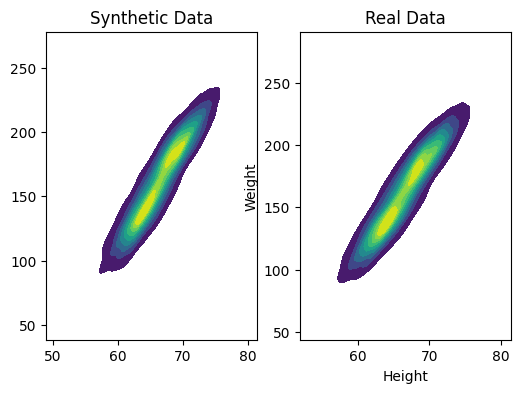

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(6,4))

sns.kdeplot(data=data, x=samples[:,0], y=samples[:,1], fill=True, cmap="viridis", ax=axes[0])
axes[0].set_title("Synthetic Data")

sns.kdeplot(data=data, x="Height", y="Weight", fill=True, cmap="viridis", ax=axes[1])
axes[1].set_title("Real Data")

We can also use mixture models to fit more complex data. Consider the moons dataset below.

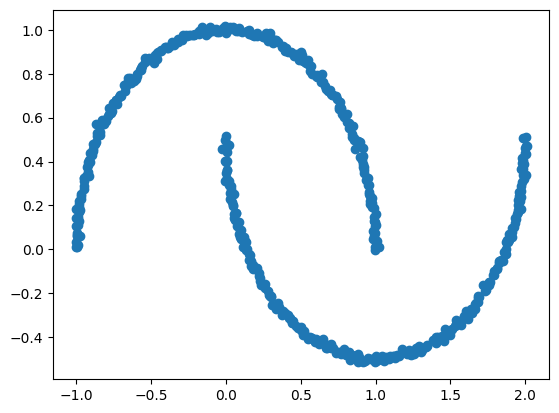

In [ ]:
X, y = ds.make_moons(n_samples=500, noise=0.01)

plt.scatter(X[:, 0], X[:,1], s=1)
plt.show()

We fit that in the same manner using more components.

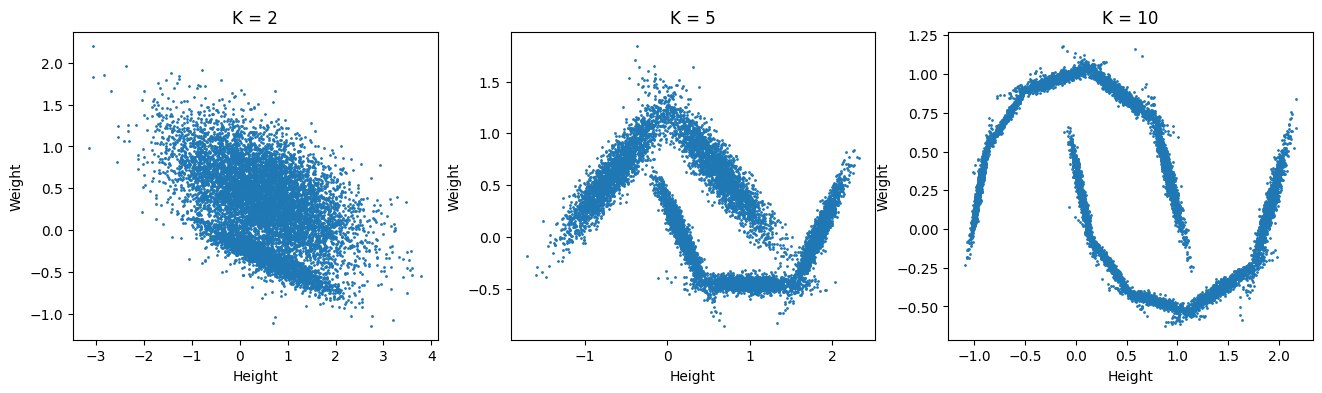

In [117]:
Ks = [2, 5, 10]
n_iterations = 100
n_samples = 10000

fig, axes = plt.subplots(1, len(Ks), figsize=(16,4))

for i, K in enumerate(Ks):
    pi, Mu, Sigma2 = fit_gmm(X, K, n_iterations)
    samples = sample_gmm(pi, Mu, Sigma2, n_samples)

    axes[i].scatter(samples[:, 0], samples[:, 1], s=1)
    axes[i].set_title(f"K = {K}")
    axes[i].set_xlabel("Height")
    axes[i].set_ylabel("Weight")

plt.show()

Let's try 15 components.

In [120]:
K = 15

n_iterations = 250
pi, Mu, Sigma2 = fit_gmm(X, K, n_iterations)

n_samples = 10000
samples = sample_gmm(pi, Mu, Sigma2, n_samples)

/tmp/ipykernel_33957/2238030485.py:21: RuntimeWarning: invalid value encountered in sqrt
  normalisation_constant = 1.0 / ((2.0 * np.pi)**(d/2) * np.sqrt(cov_determinant))
/tmp/ipykernel_33957/2238030485.py:40: RuntimeWarning: overflow encountered in exp
  exponent_term = np.exp(-0.5 * mahalanobis_distance)


ValueError: probabilities contain NaN

We've encountered two separate errors:
- **Invalid value encountered in sqrt**: For a covariance matrix to be valid, the determinant should be strictly postive. In this case, the determinant of the covariance matrix has gone singular (determinant near zero) or indefinite (determinant is negative) for at least one of the components. When we then try and compute the square root of zero or a negative number, we encounter an error. We can easily resolve this by adding a small 'jitter' to every covariance update.
- **Overflow encountered in exp**: This happens when we compute $\exp(-\frac{1}{2}(x-\mu)^\intercal\Sigma^{-1}(x-\mu))$ for a point in the tail of the distribution - when the datapoint is far from the mean, the exponent is a large negative number; different data types (integers, floats, etc) can represent a fixed range of values that, when exceed, lead to underflow or overflow. In this case, we have encountered the latter. To fix this, we can instead work in **log-space**.




In [ ]:
def e_step(X, pi, Mu, Sigma2):
    N, d = X.shape
    K = pi.shape[0]

    pdf = np.zeros((N, K))

    for k in range(K):
        cov_determinant = np.linalg.det(Sigma2[k])
        cov_inverse = np.linalg.inv(Sigma2[k])

        normalisation_constant = 1.0 / ((2.0 * np.pi)**(d/2) * np.sqrt(cov_determinant)) # <-- Problematic

        diff = X - Mu[k]
        q = diff @ cov_inverse

        mahalanobis_distance = np.sum(q * diff, axis=1)
        exponent_term = np.exp(-0.5 * mahalanobis_distance) # <--- Problematic

        pdf[:, k] = normalisation_constant * exponent_term

    numerators = pi * pdf 
    denominators = numerators.sum(axis=1, keepdims=True) 
    Gamma = numerators / denominators

    return Gamma

#### Entering Log-Space
Let's re-visit how we earlier defined the probability density function of the multivariate Gaussian:
$$\mathcal{N}(x|\mu_k, \Sigma_k)=\frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2}(x-\mu_k)^\intercal\Sigma_k^{-1}(x-\mu_k)\right)$$

Instead of evaluating this, we can instead work with its log:
$$\log\mathcal{N}(x|\mu_k, \Sigma_k)=-\frac{1}{2}\left(d \log(2\pi)+\log |\Sigma_k|+(x-\mu_k)^\intercal \Sigma^{-1}_k(x-\mu_k)\right)$$

Similarly, we also address the formula for the responsibilities:
$$\gamma_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i|\mu_k, \Sigma_k^2)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i|\mu_j, \Sigma_j^2)}$$

And take the log form: 
$$\gamma_{ik}=\frac{\exp(\log \pi_k + \log \mathcal{N}(x_i|\mu_k, \Sigma_k^2))}{\sum_j \exp (\log \pi_j + \log\mathcal{N}(x_i|\mu_j, \Sigma_j^2))}$$

Note that we are still taking the exponent and so still susceptible to underflow/overflow. 

$$a_{ik}\doteq\log \pi_k + \log \mathcal{N}(x_i|\mu_k, \Sigma_k^2))$$

And then rewriting the responsibility in terms of $a_{ik}$:
$$\gamma_{ik}=\frac{\exp(a_{ik})}{\sum_j\exp(a_{ij})}$$

We then take the log to avoid computing the exponentials directly:
$$\log\gamma_{ik}=a_{ik}-\log\sum_j\exp(a_{ij})$$

The function $\log\sum_j\exp(a_{ij})$ is known as the **log-sum-exp** (LSE) function and is found throughout machine learning.

Finally, we exponentiate at the end to yield the responsibilities safely:
$$\gamma_{ik}=\exp(a_{ik}-\text{LSE}(a_{ij}))$$

With that in mind, let's re-build our E-step in the log space.

In [128]:
from scipy.special import logsumexp

def e_step(X, pi, Mu, Sigma2):
    N, d = X.shape
    K = pi.shape[0]

    log_pdf = np.zeros((N, K))

    for k in range(K):
        # Add jitter to the diagonal covariance to avoid singular matrix
        Sigma2[k] += 1e-6 * np.eye(d)

        # Calculate log|Σ|
        sign, log_cov_determinant = np.linalg.slogdet(Sigma2[k])

        # Same as earlier
        cov_inverse = np.linalg.inv(Sigma2[k])
        diff = X - Mu[k]
        q = diff @ cov_inverse
        mahalanobis_distance = np.sum(q * diff, axis=1)

        # Use the log form to define the pdf
        log_normalisation_constant = (d * np.log(2 * np.pi) + log_cov_determinant)
        log_pdf[:, k] = -0.5 * (log_normalisation_constant + mahalanobis_distance)

    # Calculate a_ij
    log_weighted = np.log(pi) + log_pdf

    # Calculate LSE(a_ij)
    lse = logsumexp(log_weighted, axis=1, keepdims=True)

    # Calculate log gamma = a_ik - LSE(a_ij)
    log_gamma = log_weighted - lse

    # Exponentiate once at the end to yield responsibilities
    Gamma = np.exp(log_gamma)

    return Gamma


Finally, we re-visit our moons dataset.

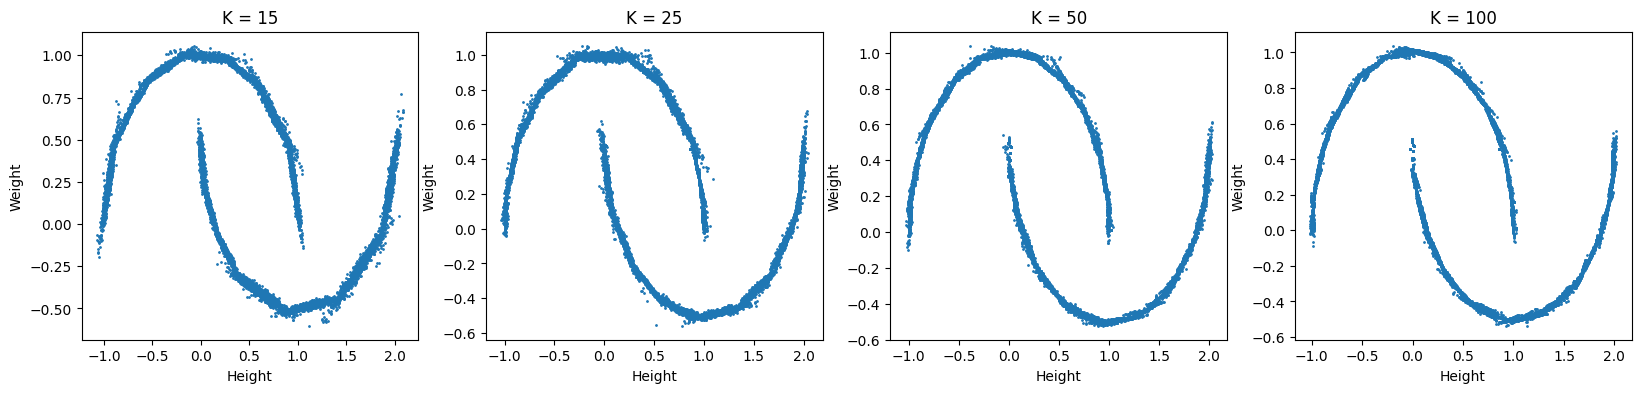

In [127]:
Ks = [15, 25, 50, 100]
n_iterations = 100
n_samples = 10000

fig, axes = plt.subplots(1, len(Ks), figsize=(20,4))

for i, K in enumerate(Ks):
    pi, Mu, Sigma2 = fit_gmm(X, K, n_iterations)
    samples = sample_gmm(pi, Mu, Sigma2, n_samples)

    axes[i].scatter(samples[:, 0], samples[:, 1], s=1)
    axes[i].set_title(f"K = {K}")
    axes[i].set_xlabel("Height")
    axes[i].set_ylabel("Weight")

plt.show()

## Conclusion
This concludes the **Mixture Models** notebook. We have seen how generative models can be defined by assuming a **discrete latent variable**, where each datapoint is softly assigned to one of a finite set of components. Mixture models are powerful for generating clustered data, and can also be extended beyond Gaussians (e.g., mixtures of binomials, Poissons).

However, they have important limitations. To capture finer structure (such as the curved structure of the moons dataset), we must increase the number of components, $K$, inflating the parameter count. Fundamentally, a discrete latent $z$ can only express which cluster a datapoint belongs to; it cannot capture degrees of variation within a cluster.

This motivates the introduction of **continuous latent variable models**, where $$z\sim\mathcal{N}(0, I), \quad x\sim p_\theta(x|z)$$

Here, $z$ lives in a continuous latent space, allowing the model to capture smooth variation, interpolate between datapoints, and represent high-dimensional structures more compactly. In the proceeding notebooks, we will explore these models, starting with **Factor Analysis**.